# Jun 14th, 2022 (ttest + ovp score new: GABAN 512)

**Motivation**: This allows to prune + calculate ovp scores in a much more principled way <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.network import *
from analysis.group import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(512)

_BOLD = 'BOLD'
_CAS = r'Ca$^{2\!\!+}$' + ' (slow)'
_CAF = r'Ca$^{2\!\!+}$' + ' (fast)'
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {_BOLD: rocket(0.6), _CAS: mako(0.6), _CAF: to_rgb('C8')} # mako(0.3)}

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [4]:
gr_ca.avg()

In [5]:
gr_ca.pi_symmetry_score()

(
    {
        1: 0.959,
        2: 0.991,
        3: 0.993,
        4: 0.993,
        5: 0.983,
        6: 0.994,
        7: 0.984,
        -1: 0.985
    },
    {
        1: 0.978,
        2: 0.993,
        3: 0.982,
        4: 0.967,
        5: 0.978,
        6: 0.982,
        7: 0.974,
        -1: 0.979
    }
)

In [6]:
pi_prune = gr_ca.prune()
pi = avg(pi_prune)

In [7]:
gr_ca.pi_symmetry_score(pi)

(
    {
        1: 0.921,
        2: 0.987,
        3: 0.991,
        4: 0.984,
        5: 0.973,
        6: 0.991,
        7: 0.97,
        -1: 0.974
    },
    {
        1: 0.982,
        2: 0.989,
        3: 0.989,
        4: 0.97,
        5: 0.982,
        6: 0.982,
        7: 0.989,
        -1: 0.983
    }
)

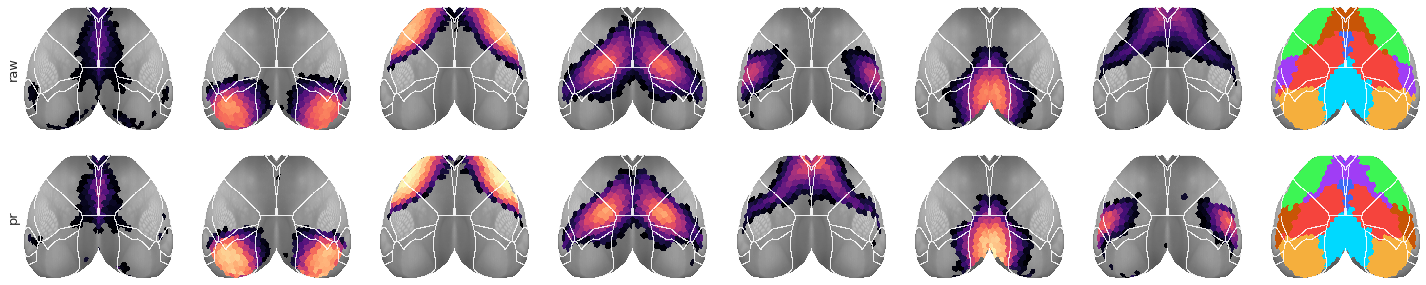

In [8]:
_ = gr_ca.show({'raw': gr_ca.pi, 'pr': pi}, vmin=0.1, vmax=1.0, figsize=(25, 5))

In [9]:
%%time

boot = bootstrap(
    x=pi_prune,
    n_resamples=int(1e3),
    statistic=lambda a: avg(a, 2, 1),
    dims=4,
)
se = bn.nanstd(boot, 0, ddof=1)
boot.shape, se.shape

CPU times: user 6min 49s, sys: 1min 41s, total: 8min 31s
Wall time: 8min 31s


((1000, 7, 542), (7, 542))

In [10]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.05)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({1.0: 268, 2.0: 189, 0.0: 5, 3.0: 79, 4.0: 1}), 0.5055350553505535)

In [11]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.1)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({1.0: 363, 2.0: 146, 0.0: 12, 3.0: 21}), 0.3302583025830258)

In [12]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.15)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({1.0: 432, 0.0: 26, 2.0: 83, 3.0: 1}), 0.20295202952029523)

In [13]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.2)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({1.0: 460, 0.0: 45, 2.0: 37}), 0.1512915129151291)

In [14]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.05)
counts = collections.Counter(reject.sum(0))
counts, 1 - counts.get(1) / sum(counts.values())

(Counter({1.0: 268, 2.0: 189, 0.0: 5, 3.0: 79, 4.0: 1}), 0.5055350553505535)

In [15]:
disjoint = reject.sum(0) == 1
mixed = reject.sum(0) > 1

In [16]:
mixed.sum() / (mixed.sum() + disjoint.sum())

0.5009310986964618

In [17]:
community_sizes = reject.sum(1)
community_sizes

array([ 78., 141., 138., 170., 148., 121.,  91.])

In [18]:
members = reject == 1
np.round((members * mixed).sum(1) / members.sum(1) * 100)

array([100.,  34.,  44.,  94.,  85.,  59.,  82.])

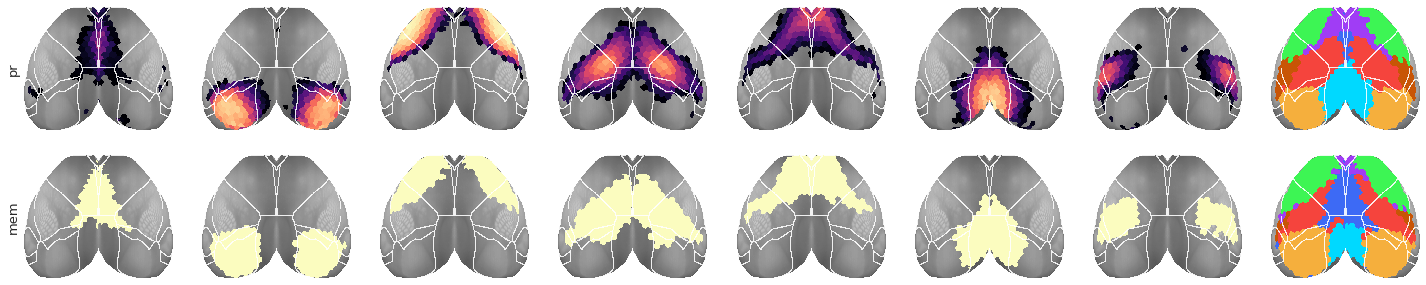

In [19]:
_ = gr_ca.show({'pr': pi, 'mem': members.astype(float)}, vmin=0.1, vmax=1.0, figsize=(25, 5))

In [20]:
members = np.zeros(pi.shape)

for i, mu in enumerate([0.5, 0.2, 0.05], start=1):
    reject, pvals = gr_ca.ttest(se, pi, mu=mu)
    members[reject == 1] += i

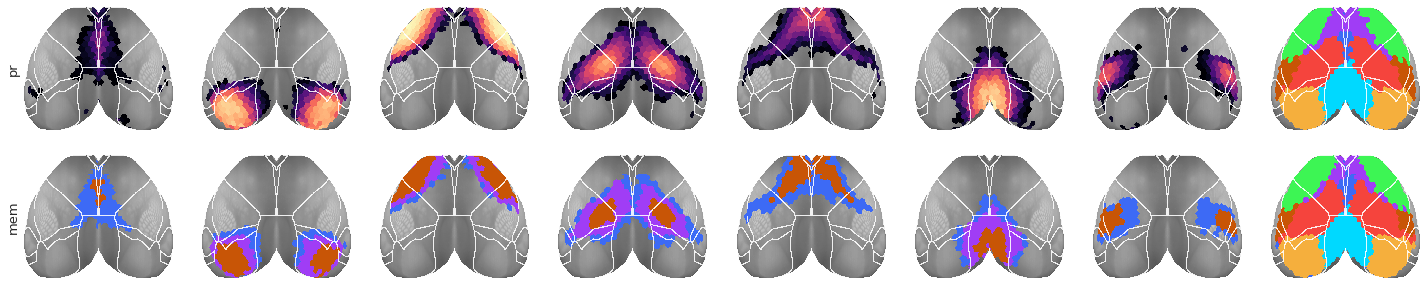

In [21]:
_ = gr_ca.show({'pr': pi, 'mem': members.astype(float)}, vmin=0.1, vmax=1.0, figsize=(25, 5))

In [22]:
members /= np.nanmax(members)

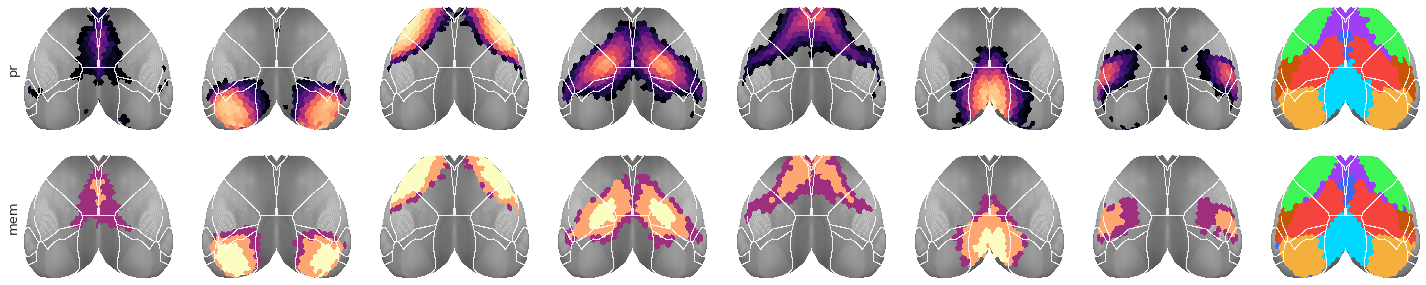

In [23]:
_ = gr_ca.show({'pr': pi, 'mem': members.astype(float)}, vmin=0.1, vmax=1.0, figsize=(25, 5))

In [24]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.05, alpha=0.05)
counts = collections.Counter(reject.sum(0))
community_sizes = reject.sum(1)
members = reject == 1

np.round((members * mixed).sum(1) / members.sum(1) * 100, 1), 1 - counts.get(1) / sum(counts.values())

(array([100. ,  34. ,  44.2,  94.1,  85.1,  58.7,  82.4]), 0.5055350553505535)

In [25]:
reject, pvals = gr_ca.ttest(se, pi, mu=0.05, alpha=0.01)
counts = collections.Counter(reject.sum(0))
community_sizes = reject.sum(1)
members = reject == 1

np.round((members * mixed).sum(1) / members.sum(1) * 100, 1), 1 - counts.get(1) / sum(counts.values())

(array([100. ,  26. ,  39.4,  92.6,  84.3,  53.7,  76.2]), 0.3468634686346863)

In [26]:
members = np.zeros(pi.shape)
alpha = 0.05

for mu in [0.5, 0.2, 0.05, 0]:
    reject, pvals = gr_ca.ttest(se, pi, mu=mu, alpha=alpha)
    members[reject == 1] += 1
members /= np.nanmax(members)

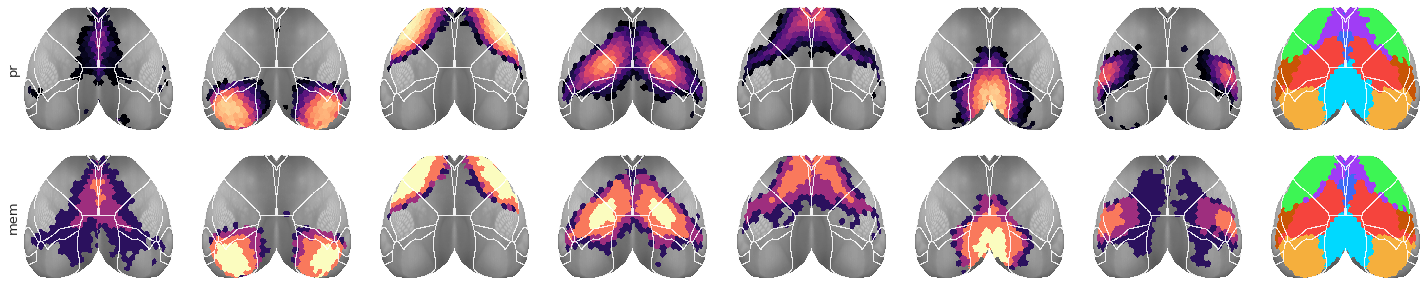

In [27]:
_ = gr_ca.show({'pr': pi, 'mem': members}, vmin=0.1, vmax=1.0, figsize=(25, 5))

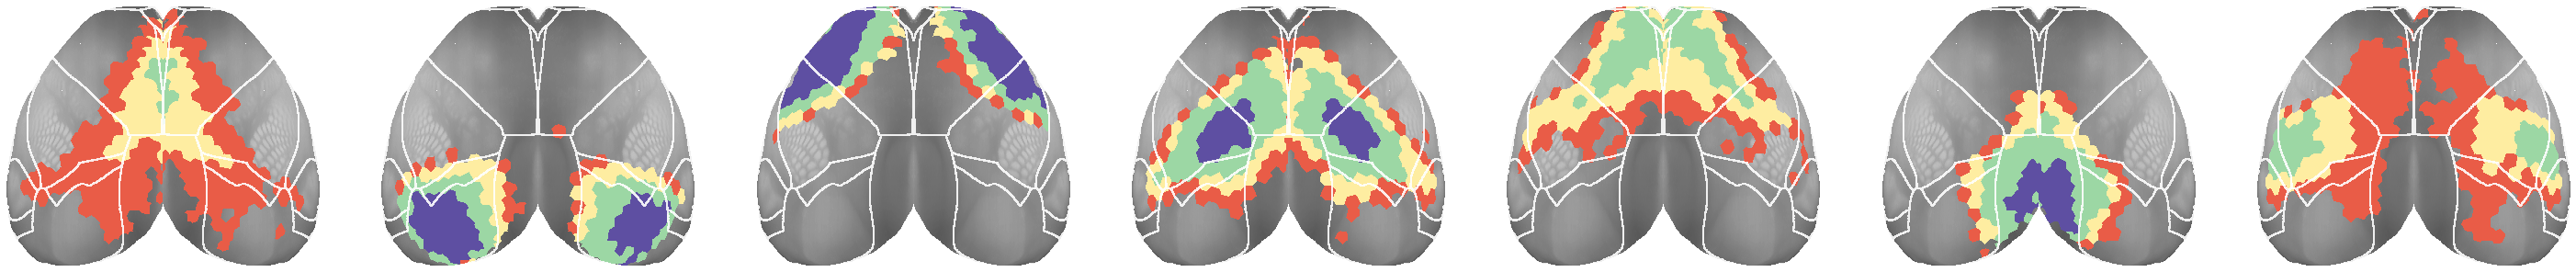

In [28]:
_ = gr_ca.show(
    data=members.astype(float),
    vmin=0.1,
    vmax=1.0,
    cmap='Spectral',
    add_disjoint=False,
    figsize=(50, 7),
)

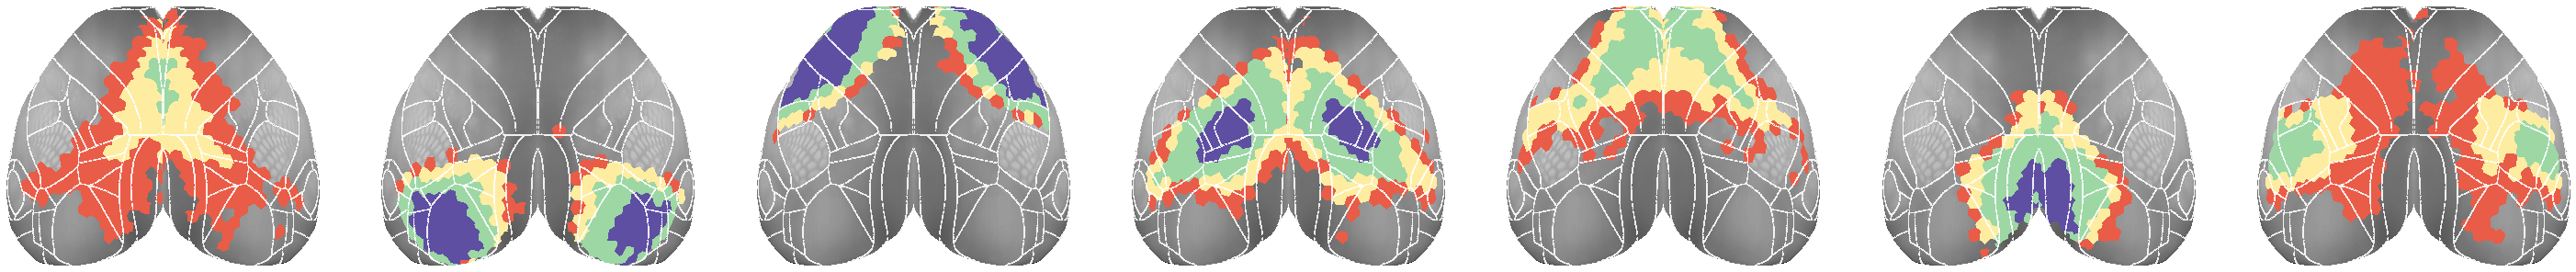

In [29]:
_ = gr_ca.show(
    data=members.astype(float),
    vmin=0.1,
    vmax=1.0,
    cmap='Spectral',
    coarse=False,
    width=0.001,
    add_disjoint=False,
    figsize=(50, 7),
)